In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import pickle
import os, re
import nltk
BASE_DIR = '../input/'
LABELED_TRAIN_DF = BASE_DIR + 'labeled_train_clean_reviews.csv'
TEST_DF = BASE_DIR + 'test_clean_reviews.csv'

In [2]:
labeled_train = pd.read_csv(LABELED_TRAIN_DF, header = 0)
test = pd.read_csv(TEST_DF, header = 0)
labeled_train["review"] = labeled_train["review"].astype(str)
test["review"] = test["review"].astype(str)
print "Read %d labeled train reviews" \
          "and %d test reviews" % (labeled_train["review"].size, test["review"].size)

Read 25000 labeled train reviewsand 25000 test reviews


Data leakage

Check if test["sentiment"] is correct

In [3]:
test["sentiment"] = test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)

In [4]:
from gensim.models import Word2Vec
EMBEDDING_DIM = 300  # Word vector dimensionality
MIN_WORD_COUNT = 40  # Minimum word count. Kaggle set to 40, to avoid attaching too much importance to individual movie titles.
NUM_THREADS = 4  # Number of threads to run in parallel
CONTEXT = 10  # Context window size
DOWNSAMPLING = 1e-3  # Downsample setting for frequent words
WORD2VEC_MODEL_FILE = BASE_DIR + \
    "word2vec_model_" + \
    str(EMBEDDING_DIM) + "dim_" + \
    str(MIN_WORD_COUNT) + "minwords_" + \
    str(CONTEXT) + "context"

word2vec_model = Word2Vec.load(WORD2VEC_MODEL_FILE)

# If you don't plan to train the model any further, calling
# init_sims will make the model much more memory-efficient.
word2vec_model.init_sims(replace=True)

print("Number of words in the word2vec model vocabulary: %d" % len(word2vec_model.wv.vocab))

Number of words in the word2vec model vocabulary: 16490


Prepare

In [5]:
train_clean_reviews = labeled_train["review"].tolist()
test_clean_reviews = test["review"].tolist()

all_clean_reviews = train_clean_reviews + test_clean_reviews

In [6]:
print(np.random.choice(all_clean_reviews, 1))

['i loved this movie because bobbie phillips can really fight  i always hate when actors are not believable in action parts  it was great to see  no offense  but a woman who can skillfully perform martial arts and fighting  if you compare this with most action movies with females you will definitely see what i mean  they don t have to cut up the shots with someone that can fight and it flows better  i was very impressed  i hope there s more']


In [7]:
# We vectorize the text corpus by turning each text into a sequence of integers
# Each integer is the index of a token in the dictionary
from keras.preprocessing.text import Tokenizer

MAX_NUM_WORDS_FOR_KERAS_TOKENIZER = 200000
#
# num_words: the maximum number of words to keep, based on frequency.
keras_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS_FOR_KERAS_TOKENIZER)
#
# fit_on_texts accepts a list of strings, a generator of strings or 
# a list of list of strings. In the last case, it assumes each entry of the lists to be a token.
# Here we provide a list of strings.
keras_tokenizer.fit_on_texts(all_clean_reviews)
word_index = keras_tokenizer.word_index
print('Keras Tokenizer found %s unique tokens' % len(word_index))
#
# texts_to_sequences transforms each text in texts to a sequence of integers.
train_sequences = keras_tokenizer.texts_to_sequences(train_clean_reviews)
test_sequences = keras_tokenizer.texts_to_sequences(test_clean_reviews)

Using TensorFlow backend.


Keras Tokenizer found 101376 unique tokens


In [8]:
# We pad all text sequences to the same length.
# By default zeros are padded at the front.
from keras.preprocessing.sequence import pad_sequences

# Set max length for each review sequence.
MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN = 500

train_pad_sequences = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN)
test_pad_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN)

In [9]:
# Prepare word embedding matrix

# Choose the smaller number of the two as column length of the matrix
num_words = min(MAX_NUM_WORDS_FOR_KERAS_TOKENIZER, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec_model.wv.vocab:
        embedding_matrix[i] = word2vec_model.wv.get_vector(word)
# Null word embeddings are words that don't exist in the embedding matrix
# and are therefore represented as zero vectors.
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 84920


In [10]:
# Split train_sequences into train and validation. Ratio: 80/20
VALIDATION_SPLIT = 0.2
np.random.seed(1234)

# 
perm = np.random.permutation(len(train_sequences))
index_train = perm[:int(len(train_sequences)*(1-VALIDATION_SPLIT))]
index_val = perm[int(len(train_sequences)*(1-VALIDATION_SPLIT)):]

x_train = train_pad_sequences[index_train]
x_val = train_pad_sequences[index_val]
y_train = labeled_train["sentiment"][index_train].tolist()
y_val = labeled_train["sentiment"][index_val].tolist()

print('Randomly split %d pad sequences for training, %d for validation' % (len(x_train) ,len(x_val)))


Randomly split 20000 pad sequences for training, 5000 for validation


In [11]:
x_test = test_pad_sequences
y_test = test["sentiment"]

## Model Architecture

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional
from keras.initializers import Constant

In [13]:
def rnn_model():
    model = Sequential()
    
    LSTM_UNITS = 32
    LSTM_DROPOUT = 0.
    LSTM_RECCURENT_DROPOUT = 0.

    embedding_layer = Embedding(
            num_words,
            EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN,
            trainable=False)
    lstm_layer = LSTM(LSTM_UNITS, dropout=LSTM_DROPOUT, 
                      recurrent_dropout=LSTM_RECCURENT_DROPOUT)
    bilstm_layer = Bidirectional(lstm_layer)
    output_layer = Dense(1, activation='sigmoid')
    
    model.add(embedding_layer)
    model.add(Dropout(0.2))
    model.add(bilstm_layer)
    model.add(Dropout(0.2))
    model.add(output_layer)
    
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [14]:
lstm_model = rnn_model()

In [15]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          30413100  
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                85248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 30,498,413
Trainable params: 85,313
Non-trainable params: 30,413,100
_________________________________________________________________


In [16]:
# batch_size: number of samples per gradient update
history = lstm_model.fit(x_train, y_train, batch_size=64, epochs=6, validation_data=[x_val, y_val])

Train on 20000 samples, validate on 5000 samples
Epoch 1/6
20000/20000 [==============================] - 524s 26ms/step - loss: 0.5077 - acc: 0.7509 - val_loss: 0.3791 - val_acc: 0.8382
Epoch 2/6
20000/20000 [==============================] - 523s 26ms/step - loss: 0.3658 - acc: 0.8457 - val_loss: 0.3562 - val_acc: 0.8512
Epoch 3/6
20000/20000 [==============================] - 524s 26ms/step - loss: 0.3378 - acc: 0.8622 - val_loss: 0.3299 - val_acc: 0.8586
Epoch 4/6
20000/20000 [==============================] - 522s 26ms/step - loss: 0.3350 - acc: 0.8623 - val_loss: 0.3834 - val_acc: 0.8572
Epoch 5/6
20000/20000 [==============================] - 523s 26ms/step - loss: 0.4561 - acc: 0.7913 - val_loss: 0.3363 - val_acc: 0.8652
Epoch 6/6
20000/20000 [==============================] - 523s 26ms/step - loss: 0.3380 - acc: 0.8586 - val_loss: 0.3030 - val_acc: 0.8748


In [17]:
y_test_pred_lstm = lstm_model.predict(x_test)

In [18]:
y_test_pred_binary_lstm = map(lambda predict: 1 if predict > 0.5 else 0, y_test_pred_lstm)

In [19]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [20]:
print("The AUC score for LSTM model is : %.5f." %roc_auc_score(y_test, y_test_pred_binary_lstm))

The AUC score for LSTM model is : 0.87520.


In [21]:
# Write the test results
output = pd.DataFrame(data={"id": test["id"], "sentiment": y_test_pred_binary_lstm})
output.to_csv(os.path.join('../', 'output', "bilstm_32units_2dropout_6epoch_new2.csv"), index=False, quoting=3)
print "Wrote bilstm_32units_2dropout_6epoch_new2.csv"

Wrote bilstm_32units_2dropout_6epoch_new2.csv


In [22]:
lstm_model.save('bilstm_word2vec_32units_2dropout_6epoch2.h5')

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

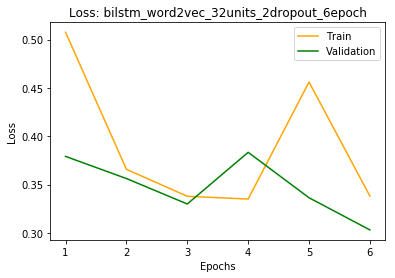

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, color='orange', label='Train')
plt.plot(epochs, val_loss, color='green', label='Validation')
plt.title('Loss: bilstm_word2vec_32units_2dropout_6epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../figures/bilstm_word2vec_32units_2dropout_6epoch_loss_new2.png', dpi=900)

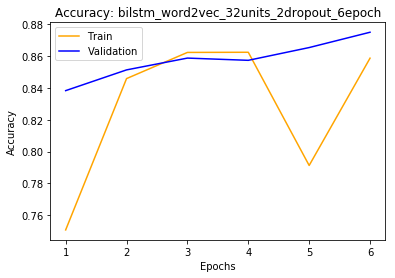

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, color='orange', label='Train')
plt.plot(epochs, val_acc, color='blue', label='Validation')
plt.title('Accuracy: bilstm_word2vec_32units_2dropout_6epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../figures/bilstm_word2vec_32units_2dropout_6epoch_accuracy_new2.png', dpi=900)